# CO$_2$ rate (g/s) prediction with XGBoost

Import necessary libraries.

In [1]:
import os
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

First, define processed data path and vehicle name. Next, read the processed data file for the given vehicle and rename the set of predictors for further steps.

In [2]:
path_home = os.path.abspath(os.getcwd())
path_data = os.path.join(path_home, 'Processed Data', 'Class I - ICEV')
vehicle = 'Nissan_Rouge_2020_(December_2019)'
data = pd.read_csv(os.path.join(path_data, vehicle + '.csv'), delimiter=',', index_col = 0)

var_names = {'Acceleration [m.s-2]':'Acceleration', 'Engine Speed [rpm]':'RPM', 'Slope [%]':'Slope', 'CO2 Rate [g.s-1]':'CO2'}
data = data[var_names.keys()]
data.rename(columns=var_names, inplace=True)

response = 'CO2'
predictors = ['RPM', 'Acceleration', 'Slope']

data.head()

,Acceleration,RPM,Slope,CO2
DateTime,,,,
2019-12-12 16:49:19,-5.551115e-16,700.0,-0.017189,0.967069
2019-12-12 16:49:20,-5.551115e-16,700.0,-0.021846,0.967069
2019-12-12 16:49:21,-5.551115e-16,700.0,-0.020522,0.967069
2019-12-12 16:49:22,-5.551115e-16,700.0,-0.017629,0.967069
2019-12-12 16:49:23,-5.551115e-16,700.0,-0.029578,0.967069


## Instantaneous readings (without lagged predictors)

Split the data into train (80%) and test sets (20%) without shuffling.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(data[predictors], data[response], test_size=0.2, shuffle=False)

Define the hyperparameter grid for XGBoost model.

In [4]:
param_grid = {
    "n_estimators" : [25, 50, 100, 200],
    "max_depth" : [1, 2, 3, 5, 7, 10],
    "eta" : [0.01, 0.05, 0.1, 0.2],
    "subsample" : [0.632, 1],
    "colsample_bytree" : [0.5, 0.8, 1]
}

Search for the best set of hyperparameters with 5-fold time series cross-validation. 

In [5]:
cv_fold = TimeSeriesSplit(n_splits=5) 
model = XGBRegressor(random_state=42)
search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=2, cv=cv_fold, scoring="neg_root_mean_squared_error")
results = search.fit(X_train, y_train)
best_model = results.best_estimator_
print('Best hyperparameters :', results.best_params_)

Best hyperparameters : {'colsample_bytree': 0.8, 'eta': 0.2, 'max_depth': 2, 'n_estimators': 25, 'subsample': 0.632}


Get the predictions for the test set.

In [6]:
y_test_pred = best_model.predict(X_test)
y_test_pred = np.maximum(y_test_pred, np.zeros(len(y_test)))
out_no_lag = pd.DataFrame({'true' : y_test, 'pred' : y_test_pred})

## With lagged predictors

Prepare data by adding lagged variables. In this example, lag is 2. Hence, the predictor set for the instance at time $t$ extends to include $[\mathbf{x}_{t-2}, \mathbf{x}_{t-1}, \mathbf{x}_t]$, where $\mathbf{x}_t$ includes engine speed, acceleration and slope at time $t$. 

In [7]:
lag = 2

cols = list()
for i in range(lag, -1, -1):
    cols.append(data[predictors].shift(i))
agg = pd.concat(cols, axis=1)
agg = pd.concat([agg, data[response]], axis=1)
agg.set_index([data.index], inplace=True)
agg.dropna(inplace=True)
lagged_data = agg.values
    
col_names = []
for i in range(lag, 0, -1):
    for col in predictors:
        col_names.append(col + "_lag" + str(i))
predictors2 = col_names + predictors 
col_names = predictors2 + [response]
lagged_data = pd.DataFrame(lagged_data, columns = col_names)
lagged_data.set_index([agg.index], inplace=True)

lagged_data.head()

,RPM_lag2,Acceleration_lag2,Slope_lag2,RPM_lag1,Acceleration_lag1,Slope_lag1,RPM,Acceleration,Slope,CO2
DateTime,,,,,,,,,,
2019-12-12 16:49:21,700.0,-5.551115e-16,-0.017189,700.0,-5.551115e-16,-0.021846,700.0,-5.551115e-16,-0.020522,0.967069
2019-12-12 16:49:22,700.0,-5.551115e-16,-0.021846,700.0,-5.551115e-16,-0.020522,700.0,-5.551115e-16,-0.017629,0.967069
2019-12-12 16:49:23,700.0,-5.551115e-16,-0.020522,700.0,-5.551115e-16,-0.017629,700.0,-5.551115e-16,-0.029578,0.967069
2019-12-12 16:49:24,700.0,-5.551115e-16,-0.017629,700.0,-5.551115e-16,-0.029578,700.0,-5.551115e-16,-0.034365,0.967069
2019-12-12 16:49:25,700.0,-5.551115e-16,-0.029578,700.0,-5.551115e-16,-0.034365,700.0,-5.551115e-16,-0.025033,0.967069


Split the data into train and test sets without shuffling. Test set includes the same set of instances as the previous example.

In [8]:
ntest = round(data.shape[0] * 0.2)
X_train, X_test, y_train, y_test = train_test_split(lagged_data[predictors2], lagged_data[response], test_size=ntest, shuffle=False)

Define the hyperparameter grid for XGBoost model.

In [9]:
param_grid = {
    "n_estimators" : [25, 50, 100, 200],
    "max_depth" : [1, 2, 3, 5, 7, 10],
    "eta" : [0.01, 0.05, 0.1, 0.2],
    "subsample" : [0.632, 1],
    "colsample_bytree" : [0.5, 0.8, 1]
}

Search for the best set of hyperparameters with 5-fold time series cross-validation. 

In [10]:
cv_fold = TimeSeriesSplit(n_splits=5) 
model = XGBRegressor(random_state=42)
search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=2, cv=cv_fold, scoring="neg_root_mean_squared_error")
results = search.fit(X_train, y_train)
best_model = results.best_estimator_
print('Best hyperparameters :', results.best_params_)

Best hyperparameters : {'colsample_bytree': 1, 'eta': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.632}


Get the predictions for the test set.

In [11]:
y_test_pred = best_model.predict(X_test)
y_test_pred = np.maximum(y_test_pred, np.zeros(len(y_test)))
out_lag = pd.DataFrame({'true' : y_test, 'pred' : y_test_pred})

## Prediction accuracy comparison

For both with and without lagged predictors, compute Mean Absolute Error (MAE) as $$MAE = \frac{1}{n_{test}} \sum_{i=1}^{n_{test}} |y_i - \hat y_i| $$ where $y_i$ is the true response and $\hat y_i$ is the predicted response for instance $i$.

In [12]:
print('MAE (instantaneous readings) = %.3f' % mean_absolute_error(out_no_lag['true'], out_no_lag['pred']))
print('MAE (with lagged predictors) = %.3f' % mean_absolute_error(out_lag['true'], out_lag['pred']))

MAE (instantaneous readings) = 0.450
MAE (with lagged predictors) = 0.423


Scatterplot of true and predicted response.

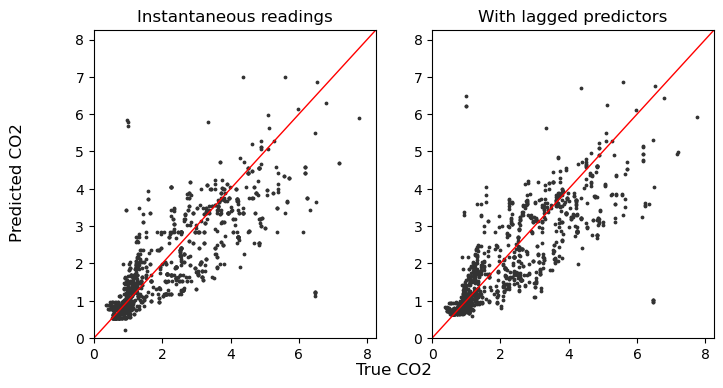

In [13]:
max_lim = max(out_no_lag['true'].max(), out_no_lag['pred'].max(), out_lag['true'].max(), out_lag['pred'].max()) + 0.5

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.scatter(out_no_lag['true'], out_no_lag['pred'], c=".2", s=3)
ax1.axline((0, 0), (1, 1), linewidth=1, color='r')
ax1.set_xlim(0, max_lim)
ax1.set_ylim(0, max_lim)
ax1.title.set_text('Instantaneous readings')
ax2.scatter(out_lag['true'], out_lag['pred'], c=".2", s=3)
ax2.axline((0, 0), (1, 1), linewidth=1, color='r')
ax2.set_xlim(0, max_lim)
ax2.set_ylim(0, max_lim)
ax2.title.set_text('With lagged predictors')
f.supxlabel('True ' + response)
f.supylabel('Predicted ' + response)
plt.show()